In [1]:
from essentia.standard import MonoLoader, TensorflowPredict2D, TensorflowPredictMusiCNN


In [12]:
embedding_model = TensorflowPredictMusiCNN(graphFilename="msd-musicnn-1.pb", output="model/dense/BiasAdd")
model = TensorflowPredict2D(
    graphFilename="moods_mirex-msd-musicnn-1.pb", input="serving_default_model_Placeholder", output="PartitionedCall"
)

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `msd-musicnn-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `moods_mirex-msd-musicnn-1.pb`


In [79]:
TRACK = "Sticky Pages - I Like Romantic.mp3"
PATH = f"/Users/fabianstermann/Music/tracks/collection/{TRACK}"
audio = MonoLoader(filename=PATH)()

embeddings = embedding_model(audio)

predictions = model(embeddings)

In [16]:
predictions.shape

(505, 5)

In [80]:
import numpy as np

average_predictions = np.mean(predictions, axis=0)

mirex_labels = [
    "Energetic",  # Cluster 1
    "Joyful",  # Cluster 2
    "Melancholic",  # Cluster 3
    "Playful",  # Cluster 4
    "Intense",  # Cluster 5
]

# Find the highest scoring cluster
predicted_label = mirex_labels[np.argmax(average_predictions)]
print(f"Predicted Mood Cluster: {predicted_label}")

# Optional: Get probabilities for all clusters
for i, label in enumerate(mirex_labels):
    print(f"{label}: {average_predictions[i]:.2f}")

threshold = 0.2

# Get all clusters above the threshold
predicted_labels = [mirex_labels[i] for i, score in enumerate(average_predictions) if score > threshold]
print(f"Predicted Moods: {', '.join(predicted_labels)}")

Predicted Mood Cluster: Intense
Energetic: 0.12
Joyful: 0.03
Melancholic: 0.10
Playful: 0.05
Intense: 0.70
Predicted Moods: Intense


In [81]:
# Set a threshold to consider a mood "strongly expressed" in a frame
frame_threshold = 0.6  # Adjust based on your data (e.g., scores above 0.6 are considered strong)

# Check how many frames are strongly associated with each cluster
strong_frames = np.sum(predictions > frame_threshold, axis=0)  # Shape: (5,)

# Calculate the proportion of strong frames for each cluster
proportion_strong_frames = strong_frames / predictions.shape[0]  # Shape: (5,)

# Define a minimum proportion to assign a label (e.g., at least 10% of frames)
label_threshold = 0.1
selected_clusters = [i for i, proportion in enumerate(proportion_strong_frames) if proportion > label_threshold]

In [82]:
# Define the cluster labels
mirex_labels = [
    "Energetic",  # Cluster 1
    "Joyful",  # Cluster 2
    "Melancholic",  # Cluster 3
    "Playful",  # Cluster 4
    "Intense",  # Cluster 5
]

# Get the labels for the selected clusters
predicted_labels = [mirex_labels[i] for i in selected_clusters]
print(f"Predicted Moods (with strong frames): {', '.join(predicted_labels)}")

Predicted Moods (with strong frames): Intense


In [ ]:
# Apply softmax frame-by-frame to normalize predictions
def framewise_softmax(predictions):
    e_x = np.exp(predictions - np.max(predictions, axis=1, keepdims=True))  # Subtract max for numerical stability
    return e_x / e_x.sum(axis=1, keepdims=True)


normalized_predictions = framewise_softmax(predictions)  # Shape remains (495, 5)

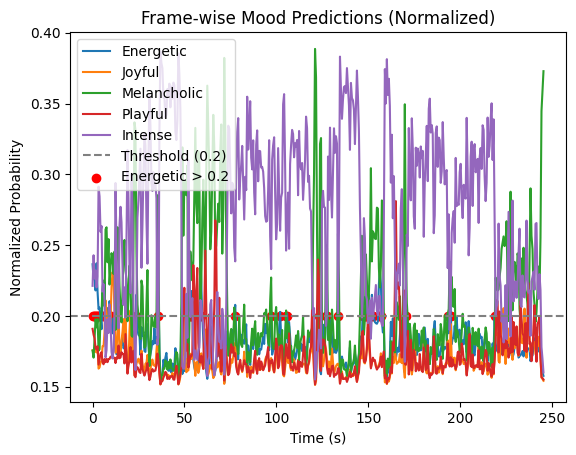

In [ ]:
import matplotlib.pyplot as plt

# Time axis based on audio length and number of frames
time = np.linspace(0, len(audio) / 44100, normalized_predictions.shape[0])  # Assuming 44.1kHz sample rate

# Plot each cluster's normalized probabilities
mirex_labels = ["Energetic", "Joyful", "Melancholic", "Playful", "Intense"]

for i, label in enumerate(mirex_labels):
    plt.plot(time, normalized_predictions[:, i], label=label)
plt.axhline(0.2, color="gray", linestyle="--", label="Threshold (0.2)")
threshold = 0.2
strong_frames = time[np.where(normalized_predictions[:, 0] > threshold)]  # For the "Energetic" cluster

plt.scatter(strong_frames, [threshold] * len(strong_frames), color="red", label="Energetic > 0.2")

plt.xlabel("Time (s)")
plt.ylabel("Normalized Probability")
plt.title("Frame-wise Mood Predictions (Normalized)")
plt.legend()
plt.show()

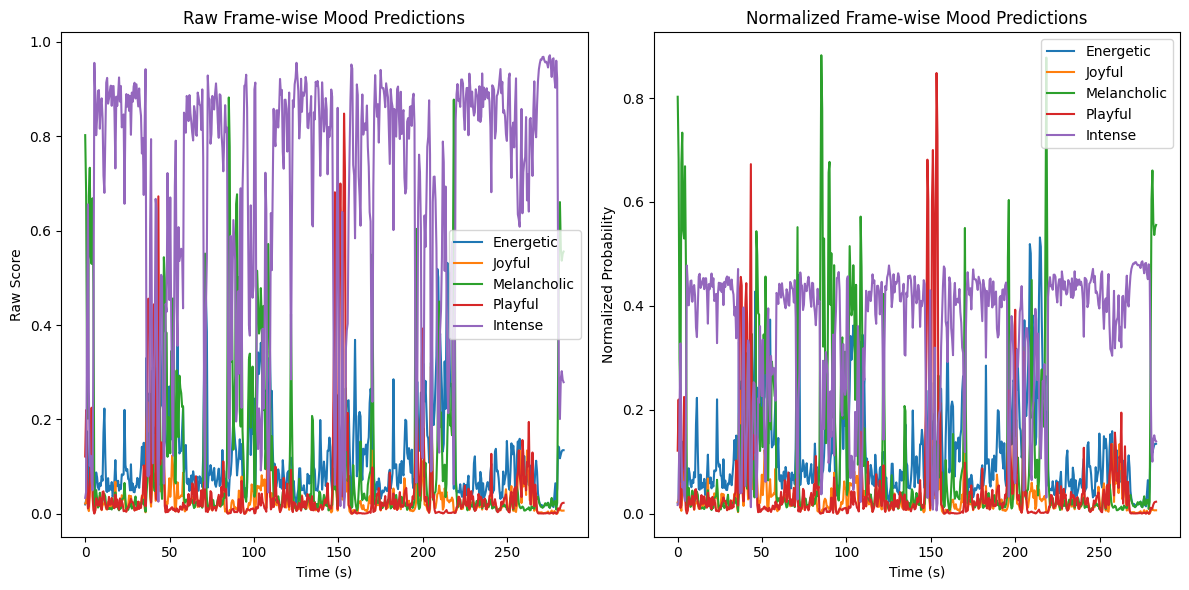

Predicted Mood Cluster: {'Energetic': 0.12037134160401428, 'Joyful': 0.030142572902379386, 'Melancholic': 0.1035827545605543, 'Playful': 0.04854517887535955, 'Intense': 0.3486790756787394}


In [83]:
# Time axis based on audio length and number of frames
time = np.linspace(0, len(audio) / 44100, predictions.shape[0])  # Assuming 44.1kHz sample rate

# Plot raw predictions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i, label in enumerate(mirex_labels):
    plt.plot(time, predictions[:, i], label=label)
plt.title("Raw Frame-wise Mood Predictions")
plt.xlabel("Time (s)")
plt.ylabel("Raw Score")
plt.legend()

# Plot normalized predictions
# Reweight the clusters (example weights)
weights = [1.0, 1.0, 1.0, 1.0, 0.5]  # Boost weaker clusters, reduce "Intense"
reweighted_predictions = predictions * weights

plt.subplot(1, 2, 2)
for i, label in enumerate(mirex_labels):
    plt.plot(time, reweighted_predictions[:, i], label=label)
plt.title("Normalized Frame-wise Mood Predictions")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Probability")
plt.legend()

plt.tight_layout()
plt.show()

# Find the highest scoring cluster
rew_average_predictions = np.mean(reweighted_predictions, axis=0)
print(f"Predicted Mood Cluster: {dict(zip(mirex_labels,  rew_average_predictions))}")


In [87]:
# reweighted_predictions_avg = reweighted_predictions / reweighted_predictions.sum()  # Normalize again
preds = np.sum(reweighted_predictions > 0.2, axis=0) / predictions.shape[0]
print(preds)
# Map back to labels
predicted_labels = [mirex_labels[i] for i, score in enumerate(preds) if score > 0.05]
# print("Reweighted Predictions:", reweighted_predictions)
print("Predicted Moods (reweighted):", predicted_labels)

[0.17366412 0.0019084  0.16984733 0.04961832 0.83015267]
Predicted Moods (reweighted): ['Energetic', 'Melancholic', 'Intense']


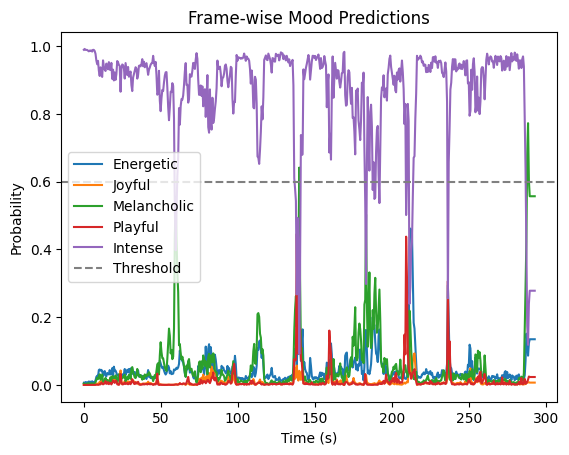

In [31]:
import matplotlib.pyplot as plt

# Plot the frame-wise probabilities for each cluster
time = np.linspace(0, len(audio) / 44100, predictions.shape[0])  # Assuming 44.1kHz sample rate
for i, label in enumerate(mirex_labels):
    plt.plot(time, predictions[:, i], label=label)

plt.axhline(frame_threshold, color="gray", linestyle="--", label="Threshold")
plt.xlabel("Time (s)")
plt.ylabel("Probability")
plt.title("Frame-wise Mood Predictions")
plt.legend()
plt.show()

In [ ]:
# Apply softmax to normalize predictions
def softmax(x):
    e_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
    return e_x / e_x.sum(axis=0)


normalized_predictions = softmax([0.05, 0.01, 0.06, 0.01, 0.87])
print("Normalized Predictions:", normalized_predictions)

Normalized Predictions: [0.16123496 0.15491285 0.1628554  0.15491285 0.36608395]


In [ ]:
# Reweight the clusters (example weights)
weights = [1.5, 2.0, 2.0, 2.0, 0.8]  # Boost weaker clusters, reduce "Intense"
reweighted_predictions = normalized_predictions * weights
reweighted_predictions /= reweighted_predictions.sum()  # Normalize again

# Map back to labels
predicted_labels = [mirex_labels[i] for i, score in enumerate(reweighted_predictions) if score > 0.1]
print("Reweighted Predictions:", reweighted_predictions)
print("Predicted Moods (reweighted):", predicted_labels)

Reweighted Predictions: [0.16340478 0.20933012 0.2200627  0.20933012 0.19787228]
Predicted Moods (reweighted): ['Energetic', 'Joyful', 'Melancholic', 'Playful', 'Intense']


In [88]:
from enum import Enum

import numpy as np
from essentia.standard import MonoLoader, TensorflowPredict2D, TensorflowPredictMusiCNN
from pydantic import BaseModel


class Mood(BaseModel):
    tag: str
    description: str
    descriptors: list[str]
    color: str
    weight: float = 1.0


class MoodType(Enum):
    ENERGETIC = Mood(
        tag="energetic",
        description="High energy, dynamic, enthusiastic, often associated with bold and assertive music styles.",
        descriptors=["Passionate", "Rousing", "Confident", "Boisterous", "Rowdy"],
        color="#FF4500",
    )
    JOYFUL = Mood(
        tag="joyful",
        description="Bright, positive, lighthearted, and playful, reflecting happiness and warmth.",
        descriptors=["Amiable/Good-natured", "Sweet", "Fun", "Rollicking", "Cheerful"],
        color="#FFD700",
    )
    MELANCHOLIC = Mood(
        tag="melancholic",
        description="Introspective and emotional, often evoking themes of nostalgia, sadness, or thoughtfulness.",
        descriptors=["Literate", "Wistful", "Bittersweet", "Autumnal", "Brooding", "Poignant"],
        color="#4682B4",
    )
    PLAYFUL = Mood(
        tag="playful",
        description="Creative, quirky, and often comedic or playful, bringing a sense of humor or irony to the music.",
        descriptors=["Witty", "Humorous", "Whimsical", "Wry", "Campy", "Quirky", "Silly"],
        color="#9370DB",
    )
    INTENSE = Mood(
        tag="intense",
        description="Powerful and dramatic, capturing tension, aggression, or emotional extremes.",
        descriptors=["Volatile", "Fiery", "Visceral", "Aggressive", "Tense/Anxious", "Intense"],
        color="#000000",
        weight=0.5,
    )


[Mood(tag='energetic', description='High energy, dynamic, enthusiastic, often associated with bold and assertive music styles.', descriptors=['Passionate', 'Rousing', 'Confident', 'Boisterous', 'Rowdy'], color='#FF4500', weight=1.0),
 Mood(tag='joyful', description='Bright, positive, lighthearted, and playful, reflecting happiness and warmth.', descriptors=['Amiable/Good-natured', 'Sweet', 'Fun', 'Rollicking', 'Cheerful'], color='#FFD700', weight=1.0),
 Mood(tag='melancholic', description='Introspective and emotional, often evoking themes of nostalgia, sadness, or thoughtfulness.', descriptors=['Literate', 'Wistful', 'Bittersweet', 'Autumnal', 'Brooding', 'Poignant'], color='#4682B4', weight=1.0),
 Mood(tag='playful', description='Creative, quirky, and often comedic or playful, bringing a sense of humor or irony to the music.', descriptors=['Witty', 'Humorous', 'Whimsical', 'Wry', 'Campy', 'Quirky', 'Silly'], color='#9370DB', weight=1.0),
 Mood(tag='intense', description='Powerful and 